# Proyek Klasifikasi Gambar: Animals Classification
- **Nama:** Melshita Ardia Kirana
- **Email:** mc006d5x1408@student.devacademy.id
- **ID Dicoding:** MC006D5X1408

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm as tq
import shutil
import pathlib
import pandas as pd
from PIL import Image
import seaborn as sns
import random

## Data Preparation

### Data Loading

In [3]:
# Install kaggle CLI
!pip install -q kaggle

# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"melshitaardia","key":"37300618b3f5bd35b0bc8a255c3a1485"}'}

In [4]:
# Buat folder .kaggle dan copy file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download dataset dari Kaggle
!kaggle datasets download -d alessiocorrado99/animals10

# Unzip dataset
!unzip -q animals10.zip

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0


In [6]:
# Ganti nama direktori hasil ekstraksi agar lebih jelas
shutil.move('raw-img', 'animals_ds')

# Tentukan nama folder utama dataset
dataset_dir = 'animals_ds'

# Daftar perubahan nama folder dari bahasa Italia ke Inggris
label_translation = {
    'cane': 'dogs',
    'cavallo': 'horses',
    'elefante': 'elephants',
    'farfalla': 'butterflys',
    'gallina': 'chickens',
    'gatto': 'cats',
    'mucca': 'cows',
    'pecora': 'sheeps',
    'ragno': 'spiders',
    'scoiattolo': 'squirrels',
}

# Ubah nama-nama folder label sesuai dengan terjemahan
for original, translated in label_translation.items():
    original_path = os.path.join(dataset_dir, original)
    translated_path = os.path.join(dataset_dir, translated)
    if os.path.exists(original_path):
        os.rename(original_path, translated_path)
        print(f"Renamed '{original}' to '{translated}'")
    else:
        print(f"Folder '{original}' not found.")

Renamed 'cane' to 'dogs'
Renamed 'cavallo' to 'horses'
Renamed 'elefante' to 'elephants'
Renamed 'farfalla' to 'butterflys'
Renamed 'gallina' to 'chickens'
Renamed 'gatto' to 'cats'
Renamed 'mucca' to 'cows'
Renamed 'pecora' to 'sheeps'
Renamed 'ragno' to 'spiders'
Renamed 'scoiattolo' to 'squirrels'


### Data Preprocessing

#### Data Augmentation

In [7]:
import os
import shutil
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator

original_path = 'animals_ds'
augmented_path = 'augmented_animals'  # folder baru hasil augmentasi

# Inisialisasi ImageDataGenerator
augmentor = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ukuran augmentasi per gambar
AUG_PER_IMG = 2
image_size = (150, 150)

# Proses augmentasi
os.makedirs(augmented_path, exist_ok=True)
all_data = []

for class_name in sorted(os.listdir(original_path)):
    class_dir = os.path.join(original_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    dest_class_dir = os.path.join(augmented_path, class_name)
    os.makedirs(dest_class_dir, exist_ok=True)

    for img_file in tqdm(os.listdir(class_dir), desc=f"Augmenting '{class_name}'"):
        img_path = os.path.join(class_dir, img_file)
        try:
            img = load_img(img_path, target_size=image_size)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            # Simpan gambar asli
            new_name = f"{os.path.splitext(img_file)[0]}_orig.jpg"
            img.save(os.path.join(dest_class_dir, new_name))
            all_data.append({'path': os.path.join(dest_class_dir, new_name), 'label': class_name})

            # Simpan hasil augmentasi
            aug_iter = augmentor.flow(x, batch_size=1)
            for i in range(AUG_PER_IMG):
                aug_img = array_to_img(next(aug_iter)[0])
                aug_name = f"{os.path.splitext(img_file)[0]}_aug{i}.jpg"
                aug_img.save(os.path.join(dest_class_dir, aug_name))
                all_data.append({'path': os.path.join(dest_class_dir, aug_name), 'label': class_name})
        except Exception as e:
            print(f"Failed to process {img_path}: {e}")

Augmenting 'squirrels': 100%|██████████| 1862/1862 [00:20<00:00, 92.34it/s]


#### Split Dataset

In [8]:
from sklearn.model_selection import train_test_split

# Buat dataframe dari hasil augmentasi
df_aug = pd.DataFrame(all_data)

# Split 80% train, 10% val, 10% test (set stratify agar seimbang)
X = df_aug['path']
y = df_aug['label']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1111, stratify=y_trainval, random_state=42)

# Gabungkan dataframe dan beri label set
df_train = pd.DataFrame({'path': X_train, 'label': y_train, 'set': 'train'})
df_val   = pd.DataFrame({'path': X_val, 'label': y_val, 'set': 'val'})
df_test  = pd.DataFrame({'path': X_test, 'label': y_test, 'set': 'test'})

df_final = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Cek distribusi
print(df_final.groupby(['set', 'label']).size())

dataset_final_path = 'DatasetFinal'

for _, row in tqdm(df_final.iterrows(), total=len(df_final), desc="Copying to final structure"):
    src = row['path']
    dst_dir = os.path.join(dataset_final_path, row['set'], row['label'])
    os.makedirs(dst_dir, exist_ok=True)
    dst_path = os.path.join(dst_dir, os.path.basename(src))
    shutil.copy2(src, dst_path)

set    label     
test   butterflys      634
       cats            500
       chickens        929
       cows            560
       dogs           1459
       elephants       434
       horses          787
       sheeps          546
       spiders        1446
       squirrels       559
train  butterflys     5069
       cats           4004
       chickens       7436
       cows           4478
       dogs          11671
       elephants      3470
       horses         6295
       sheeps         4368
       spiders       11571
       squirrels      4468
val    butterflys      633
       cats            500
       chickens        929
       cows            560
       dogs           1459
       elephants       434
       horses          787
       sheeps          546
       spiders        1446
       squirrels       559
dtype: int64


Copying to final structure: 100%|██████████| 78537/78537 [00:17<00:00, 4470.39it/s]


## Modelling

In [11]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Set direktori
TRAIN_DIR = "DatasetFinal/train"
VAL_DIR = "DatasetFinal/val"

# ImageDataGenerator dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Image Generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# MobileNetV2 dengan input 224x224
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Fine-tune layer atas saja
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

n_classes = train_generator.num_classes

# Build model
model_mobilenet = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
])

# Compile model
model_mobilenet.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_mobilenet.summary()

# Callbacks
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

callbacks_list = [earlystop, reduce_lr]

from sklearn.utils.class_weight import compute_class_weight
class_labels = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(class_weight='balanced',
                                        classes=np.unique(train_generator.classes),
                                        y=train_generator.classes)

class_weights = dict(zip(range(len(class_labels)), class_weights))


# Train
history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks_list
)

Found 62830 images belonging to 10 classes.
Found 7853 images belonging to 10 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,322 (11.49 MB)

 Trainable params: 1,961,034 (7.48 MB)

 Non-trainable params: 1,052,288 (4.01 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 677s 674ms/step - accuracy: 0.5848 - loss: 1.4452 - val_accuracy: 0.8797 - val_loss: 0.3977 - learning_rate: 5.0000e-05
Epoch 2/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 654s 666ms/step - accuracy: 0.8512 - loss: 0.5147 - val_accuracy: 0.9012 - val_loss: 0.3186 - learning_rate: 5.0000e-05
Epoch 3/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 648s 660ms/step - accuracy: 0.8830 - loss: 0.4006 - val_accuracy: 0.9148 - val_loss: 0.2688 - learning_rate: 5.0000e-05
Epoch 4/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 650s 661ms/step - accuracy: 0.8992 - loss: 0.3340 - val_accuracy: 0.9269 - val_loss: 0.2385 - learning_rate: 5.0000e-05
Epoch 5/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 657s 669ms/step - accuracy: 0.9158 - loss: 0.2874 - val_accuracy: 0.9389 - val_loss: 0.1933 - learning_rate: 5.0000e-05
Epoch 6/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 649s 661ms/step - accuracy: 0.9250 - loss: 0.2478 - val_accuracy: 0.9436 - val_loss: 0.1789 - learning_rate: 5.0000e-05
Epoch 7/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluasi dan Visualisasi

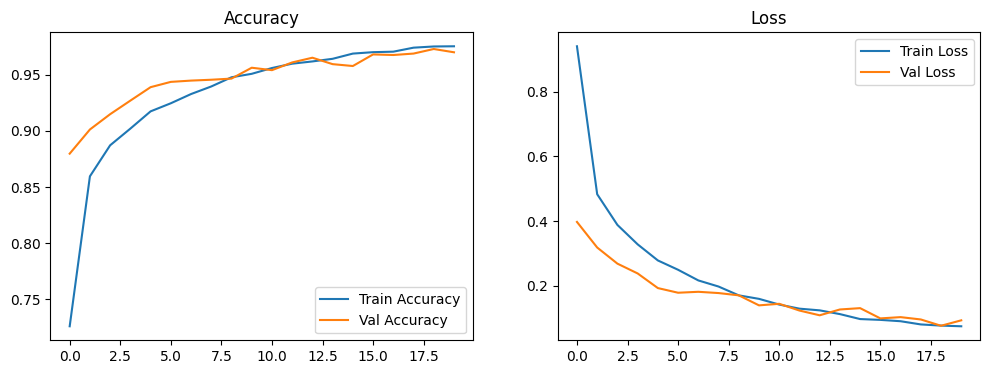

In [12]:
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

Found 7854 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


246/246 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step
              precision    recall  f1-score   support

  butterflys       0.99      0.97      0.98       634
        cats       0.95      0.97      0.96       500
    chickens       0.98      0.98      0.98       929
        cows       0.96      0.93      0.95       560
        dogs       0.96      0.97      0.97      1459
   elephants       0.97      0.98      0.97       434
      horses       0.97      0.97      0.97       787
      sheeps       0.97      0.94      0.95       546
     spiders       0.99      0.99      0.99      1446
   squirrels       0.98      0.98      0.98       559

    accuracy                           0.97      7854
   macro avg       0.97      0.97      0.97      7854
weighted avg       0.97      0.97      0.97      7854



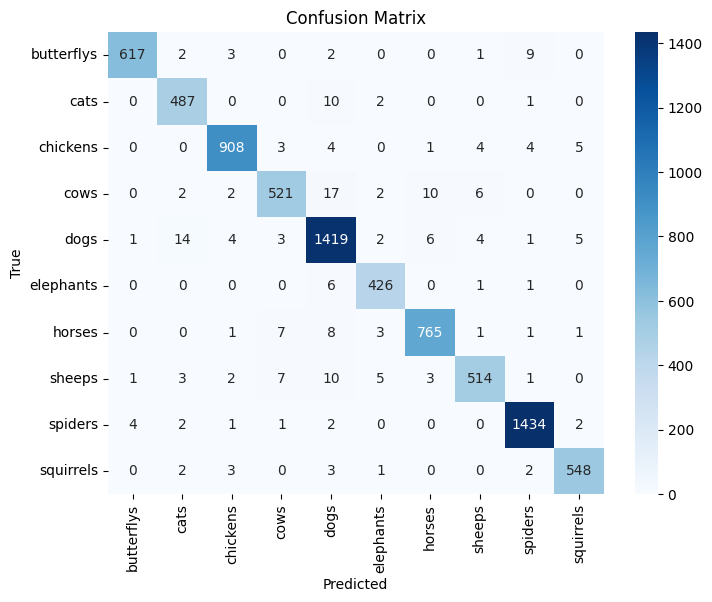

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator


TEST_DIR = "DatasetFinal/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predict
y_pred = model_mobilenet.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Konversi Model

In [16]:
import os
import tensorflow as tf
import tensorflowjs as tfjs
from google.colab import drive
drive.mount('/content/drive2')

# Path penyimpanan utama
EXPORT_DIR = '/content/drive2/MyDrive/Dicoding/Project Klasifikasi Gambar/Proyek/Submission'

# Simpan sebagai SavedModel
saved_model_path = os.path.join(EXPORT_DIR, 'saved_model')
model_mobilenet.export(saved_model_path)
print("✅ SavedModel exported to:", saved_model_path)

# Konversi ke TFLite
tflite_dir = os.path.join(EXPORT_DIR, 'tflite')
os.makedirs(tflite_dir, exist_ok=True)

tflite_model_path = os.path.join(tflite_dir, 'model.tflite')
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print("✅ TFLite model saved to:", tflite_model_path)

# Simpan label.txt
labels = list(train_generator.class_indices.keys())
label_file_path = os.path.join(tflite_dir, 'label.txt')
with open(label_file_path, 'w') as f:
    f.write('\n'.join(labels))
print("✅ label.txt saved to:", label_file_path)

# Konversi ke TensorFlow.js
tfjs_dir = os.path.join(EXPORT_DIR, 'tfjs_model')
tfjs.converters.convert_tf_saved_model(saved_model_path, tfjs_dir)
print("✅ TFJS model saved to:", tfjs_dir)

Mounted at /content/drive2
Saved artifact at '/content/drive2/MyDrive/Dicoding/Project Klasifikasi Gambar/Proyek/Submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_484')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134039891918288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134039891917328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134039891916944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134039891917712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134039891916560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134042109819408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134039891915408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134039444209744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134039891916176: TensorSpec(shape=(), dtype=tf.re

## Inference (Optional)

#### Menggunakan tflite

Drive already mounted at /content/drive2; to attempt to forcibly remount, call drive.mount("/content/drive2", force_remount=True).


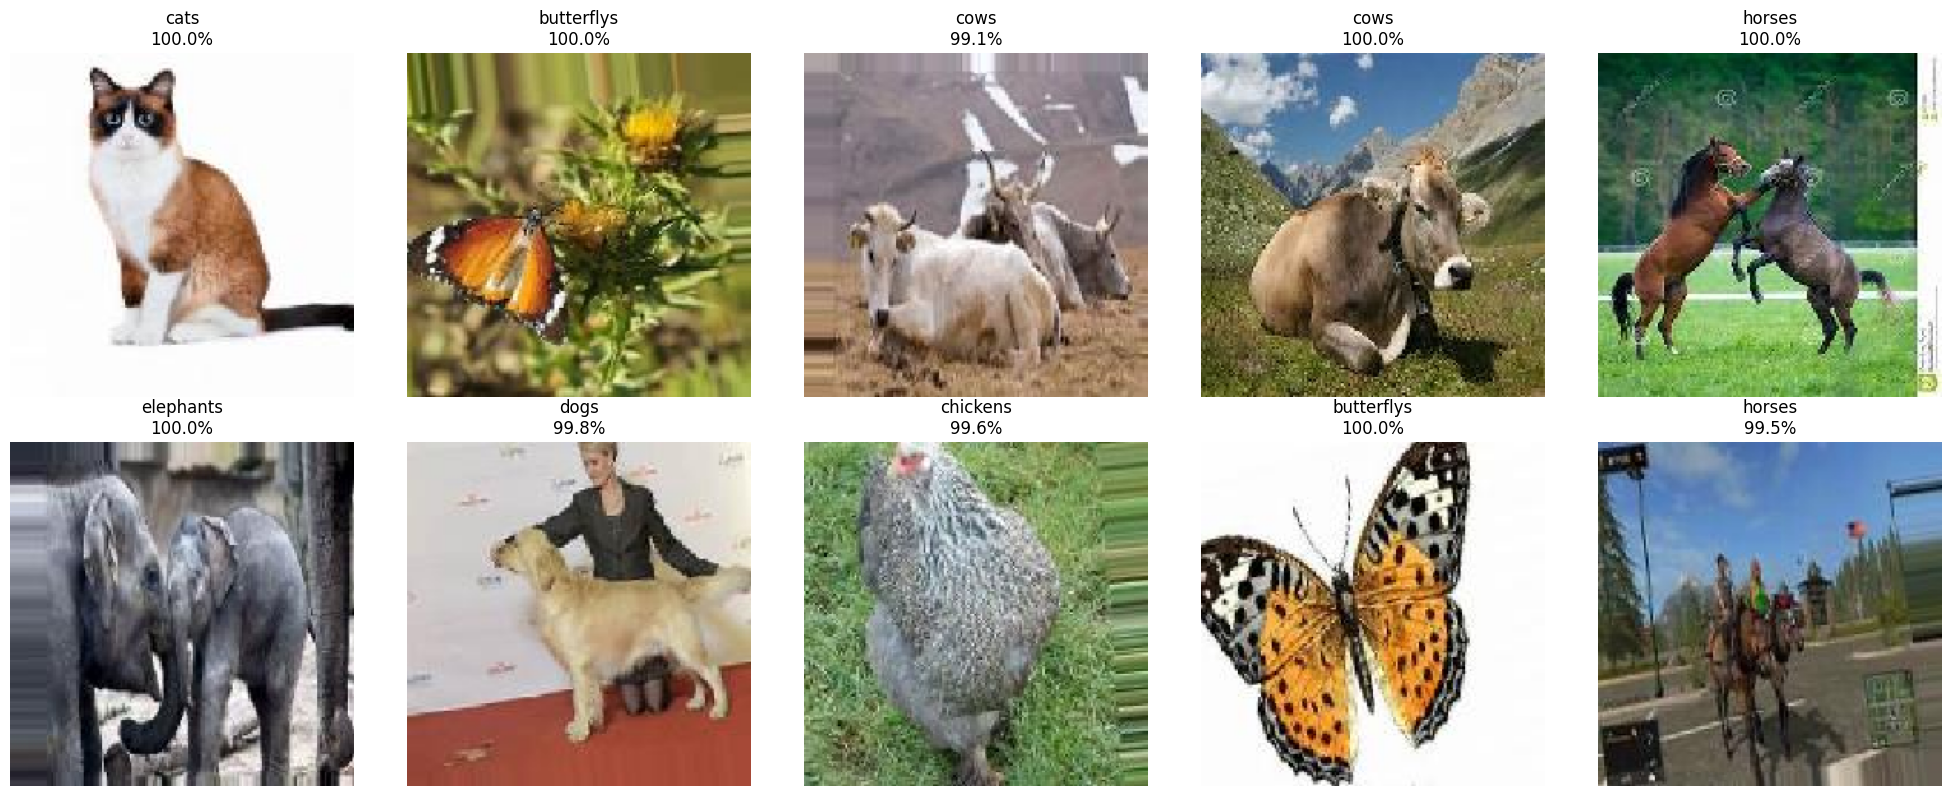


Gambar ke-1: 1294_aug0.jpg
Prediksi: cats
Confidence tiap kelas:
  butterflys  : 0.00%
  cats        : 100.00%
  chickens    : 0.00%
  cows        : 0.00%
  dogs        : 0.00%
  elephants   : 0.00%
  horses      : 0.00%
  sheeps      : 0.00%
  spiders     : 0.00%
  squirrels   : 0.00%

Gambar ke-2: OIP-uCzOKbqXmNisai2Q2enk-QHaHf_aug0.jpg
Prediksi: butterflys
Confidence tiap kelas:
  butterflys  : 100.00%
  cats        : 0.00%
  chickens    : 0.00%
  cows        : 0.00%
  dogs        : 0.00%
  elephants   : 0.00%
  horses      : 0.00%
  sheeps      : 0.00%
  spiders     : 0.00%
  squirrels   : 0.00%

Gambar ke-3: OIP-ckbM79Iddn44A3FRSTlseAHaEw_aug0.jpg
Prediksi: cows
Confidence tiap kelas:
  butterflys  : 0.00%
  cats        : 0.00%
  chickens    : 0.00%
  cows        : 99.08%
  dogs        : 0.01%
  elephants   : 0.00%
  horses      : 0.01%
  sheeps      : 0.89%
  spiders     : 0.00%
  squirrels   : 0.00%

Gambar ke-4: OIP-chdqMCoeMCu1PJ9MDrFSZQHaF7_orig.jpg
Prediksi: cows
Confidence

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.preprocessing import image
from google.colab import drive

drive.mount('/content/drive2')

# Path model TFLite
tflite_model_path = '/content/drive2/MyDrive/Dicoding/Project Klasifikasi Gambar/Proyek/Submission/tflite/model.tflite'

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Ambil input dan output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Dataset path untuk testing
TEST_DIR = 'DatasetFinal/test'
class_names = sorted(os.listdir(TEST_DIR))

# Ambil semua path gambar dari folder test
image_paths = []
for label in class_names:
    label_dir = os.path.join(TEST_DIR, label)
    image_files = [os.path.join(label_dir, fname) for fname in os.listdir(label_dir)
                   if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]
    image_paths.extend(image_files)

# Ambil 10 gambar random
sample_paths = random.sample(image_paths, 10)

# Visualisasi dan prediksi
plt.figure(figsize=(20, 8))

for i, path in enumerate(sample_paths):
    img = image.load_img(path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    # Inference
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    pred_label = class_names[np.argmax(output_data)]
    confidence = np.max(output_data)

    # Tampilkan gambar
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{pred_label}\n{confidence*100:.1f}%")

plt.tight_layout()
plt.show()

# Cetak detail confidence tiap gambar
for i, path in enumerate(sample_paths):
    img = image.load_img(path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    print(f"\nGambar ke-{i+1}: {os.path.basename(path)}")
    print(f"Prediksi: {class_names[np.argmax(output_data)]}")
    print("Confidence tiap kelas:")
    for idx, label in enumerate(class_names):
        print(f"  {label:12s}: {output_data[0][idx]*100:.2f}%")